# Data Preparation and Segmentation

## Introducción
Esta notebook se centra en la preparación y segmentación de los datos. La limpieza de los datos y la segmentación de productos según criterios específicos nos permitirán mejorar la precisión de los modelos de predicción.


## 1. Importación de Librerías

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 2. Configuración del Entorno

In [2]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# Configuración de estilo para las visualizaciones
sns.set(style="whitegrid")

# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [4]:
# Cargar los datos desde archivos CSV
df = pd.read_excel(f'{data_dir}db_.xlsx', 'BBDD')

print(df.shape)
df.head()

(92212, 6)


,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000
1,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,120987.0000
2,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,299285.0000
3,2020-11-05,2020-12-04,2020-11-29,Ganadería,6,1824520.0000
4,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,89883.0000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92212 entries, 0 to 92211
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               92212 non-null  datetime64[ns]
 1   expirationDate     92212 non-null  datetime64[ns]
 2   paymentDate        84946 non-null  datetime64[ns]
 3   sector             90543 non-null  object        
 4   payerSalesSegment  92212 non-null  int64         
 5   amountFinanced     92210 non-null  float64       
dtypes: datetime64[ns](3), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


## 4. Reconstruccion historico

4.1. Estructuracion

In [7]:
## generar indice por factura
df_=df.sort_values("date").reset_index(drop=True).reset_index(names="id")
df_.head(2)

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000
1,1,2020-11-05,2020-12-30,2020-12-28,Relacionados a Construccion,5,88155.0000


4.2. Estructuracion

Tomo el criterio de tomar fechas de cortes de forma mensual a fin de mes, esto ayuda analizar en el pasado la situacion de cada factura a fin de mes 

In [8]:
## Reconstruccion de historial

fecha_fin = df_['date'].max()+ pd.offsets.MonthEnd(0) # llevar ultima fecha de corte
current_date = df_['date'].min().replace(day=1)

fecha_final = df_['date'].max()

# Generar todas las fechas de inicio y fin de mes en el rango
fechas_inicio = pd.date_range(start=current_date, end=fecha_fin, freq='MS')
fechas_fin = pd.date_range(start=current_date, end=fecha_fin, freq='ME')

# Almacenar resultados temporalmente en una lista
resultados = []

# Loop por cada rango mensual
for start_date, end_date in tqdm(zip(fechas_inicio, fechas_fin)):
    # Ajustar end_date si excede fecha_fin
    if end_date > fecha_final:
        end_date = fecha_final # fecha de ultima foto

    # Filtrar facturas activas del período anterior
    if len(resultados) > 0:
        # Concatenar resultados acumulados
        df_acumulado = pd.concat(resultados, ignore_index=True)
        
        # Obtener facturas activas en la fecha anterior
        fecha_corte_anterior = start_date - pd.Timedelta(days=1)
        df_status = df_[df_["id"].isin(
            df_acumulado[
                (df_acumulado["paymentDate"].isnull()) &
                (df_acumulado["fecha_corte"] == fecha_corte_anterior)
            ]['id'].unique()
        )].copy() 
        df_status["paymentDate"] = np.where(
            df_status["paymentDate"] > end_date, pd.NA, df_status["paymentDate"]
        )
        df_status.loc[:, "fecha_corte"] = end_date
        resultados.append(df_status)

    # Filtrar facturas creadas en el rango actual
    df_tmp_nuevo = df_[df_["date"].between(start_date, end_date)].copy() 
    df_tmp_nuevo["paymentDate"] = np.where(
        df_tmp_nuevo["paymentDate"] > end_date, pd.NA, df_tmp_nuevo["paymentDate"]
    )
    df_tmp_nuevo.loc[:, "fecha_corte"] = end_date
    resultados.append(df_tmp_nuevo)

# Combinar todos los resultados al final
df_result = pd.concat(resultados, ignore_index=True)

# Asegurar formatos de fecha
df_result['paymentDate'] = pd.to_datetime(df_result['paymentDate'])
df_result.head()

19it [00:00, 130.71it/s]


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30


In [9]:
df_result["fecha_corte"].min(),df_result["fecha_corte"].max()

(Timestamp('2020-11-30 00:00:00'), Timestamp('2022-05-28 00:00:00'))

In [10]:
## caso testigo 
df_[df_["paymentDate"]>(df_["date"]+pd.Timedelta(days=180))].head()

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
1784,1784,2020-11-21,2020-12-17,2021-06-13,Servicios de Salud,1,8710502.0000
3588,3588,2020-12-11,2021-01-25,2021-07-07,Comercio,2,6489369.0000
4202,4202,2020-12-17,2021-03-16,2021-06-30,Construcción Ingeniería e Infraestructura,5,2204032.0000
5864,5864,2021-01-04,2021-04-01,2021-12-10,Construcción de Viviendas,4,440824.0000
5865,5865,2021-01-04,2021-04-01,2021-12-10,Construcción de Viviendas,4,83033.0000


In [11]:
df_result['expirationDays'] = (df_result['expirationDate'] - df_result['date']).dt.days
df_result['paymentDays'] = np.where(df_result['paymentDate'].isnull(),(df_result['fecha_corte'] - df_result['expirationDate']).dt.days, # fecha de corte "foto"
                             (df_result['paymentDate'] - df_result['expirationDate']).dt.days)

df_result.head()


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30,29,-5.0000
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30,55,-30.0000
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30,29,-4.0000
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30,32,-7.0000
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30,29,-5.0000


In [12]:
# esta factura se puede apreciar como mes a mes fue evolucionando sus dias de mora hasta la fecha de pago
df_result[df_result["id"]==1784]

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
1784,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-11-30,26,-17.0000
4215,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-12-31,26,14.0000
8590,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-01-31,26,45.0000
16644,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-02-28,26,73.0000
26110,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-03-31,26,104.0000
36197,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-04-30,26,134.0000
45944,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-05-31,26,165.0000
57311,1784,2020-11-21,2020-12-17,2021-06-13,Servicios de Salud,1,8710502.0000,2021-06-30,26,178.0000


In [14]:
# guardo base
df_result.to_parquet(f'{data_dir}complete_data.parquet')

## 5. VD

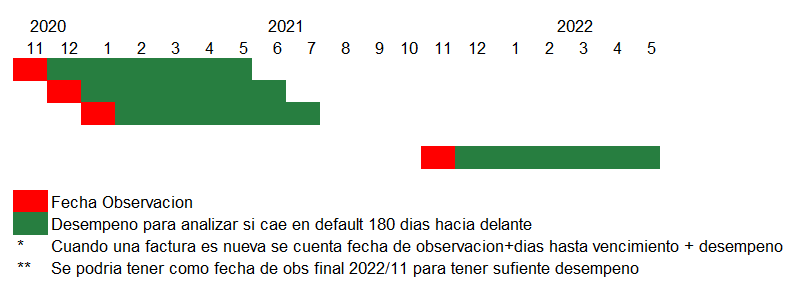


In [15]:
complete_data=pd.read_parquet(f'{data_dir}complete_data.parquet')
print(complete_data.shape)

complete_data.head()


(223983, 10)


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30,29,-5.0000
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30,55,-30.0000
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30,29,-4.0000
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30,32,-7.0000
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30,29,-5.0000


In [23]:
df_id=complete_data[["id","fecha_corte",'date',"paymentDays",'expirationDate','paymentDate']].copy()
df_id.head()


,id,fecha_corte,date,paymentDays,expirationDate,paymentDate
0,0,2020-11-30,2020-11-05,-5.0000,2020-12-04,2020-11-29
1,1,2020-11-30,2020-11-05,-30.0000,2020-12-30,NaT
2,2,2020-11-30,2020-11-05,-4.0000,2020-12-04,NaT
3,3,2020-11-30,2020-11-05,-7.0000,2020-12-07,NaT
4,4,2020-11-30,2020-11-05,-5.0000,2020-12-04,2020-11-29


In [24]:
df_id["fecha_default"]=(df_id["expirationDate"]+pd.Timedelta(days=180))+pd.offsets.MonthEnd(0)

df_id["fecha_default"]=np.where(df_id["fecha_corte"]>df_id["fecha_default"],
                                df_id["fecha_corte"],df_id["fecha_default"]) # para facturas que en la fecha de analisis ya superaron los 180 dias
df_id.head()

,id,fecha_corte,date,paymentDays,expirationDate,paymentDate,fecha_default
0,0,2020-11-30,2020-11-05,-5.0000,2020-12-04,2020-11-29,2021-06-30
1,1,2020-11-30,2020-11-05,-30.0000,2020-12-30,NaT,2021-06-30
2,2,2020-11-30,2020-11-05,-4.0000,2020-12-04,NaT,2021-06-30
3,3,2020-11-30,2020-11-05,-7.0000,2020-12-07,NaT,2021-06-30
4,4,2020-11-30,2020-11-05,-5.0000,2020-12-04,2020-11-29,2021-06-30


In [25]:
# caso testigo 
df_id[df_id["id"]==5493] # esta factura a partir del 2021-10-31 se considera como un malo observado, es decir ya esta en default en el analisis

,id,fecha_corte,date,paymentDays,expirationDate,paymentDate,fecha_default
7920,5493,2020-12-31,2020-12-31,-97.0000,2021-04-07,NaT,2021-10-31
11545,5493,2021-01-31,2020-12-31,-66.0000,2021-04-07,NaT,2021-10-31
18074,5493,2021-02-28,2020-12-31,-38.0000,2021-04-07,NaT,2021-10-31
27013,5493,2021-03-31,2020-12-31,-7.0000,2021-04-07,NaT,2021-10-31
36427,5493,2021-04-30,2020-12-31,23.0000,2021-04-07,NaT,2021-10-31
46011,5493,2021-05-31,2020-12-31,54.0000,2021-04-07,NaT,2021-10-31
57329,5493,2021-06-30,2020-12-31,84.0000,2021-04-07,NaT,2021-10-31
69659,5493,2021-07-31,2020-12-31,115.0000,2021-04-07,NaT,2021-10-31
83570,5493,2021-08-31,2020-12-31,146.0000,2021-04-07,NaT,2021-10-31
97968,5493,2021-09-30,2020-12-31,176.0000,2021-04-07,NaT,2021-10-31


In [49]:
import pandasql as psql

# Definir la consulta SQL ajustada
query = """
WITH merged_data AS (SELECT 
    a.id, 
    DATE(a.fecha_corte) as fecha_observacion,
    DATE(a.date) date,
    DATE(a.expirationDate) expirationDate,
    DATE(a.paymentDate) paymentDate,
    --DATE(DATE(a.expirationDate, '+6 months'), 'start of month', '+1 month', '-1 day') expirationDate_180 ,
    DATE(a.expirationDate, '+180 days') expirationDate_180 ,
    case when b.paymentDate is null then 0 else 1 end as pago,
    case when a.fecha_corte=b.fecha_corte then b.paymentDays else 0 end m_dven_0,
    b.fecha_corte,
    b.paymentDays
FROM 
    df_id a
inner JOIN 
    df_id b
ON a.id = b.id 
    AND a.fecha_corte <= b.fecha_corte 
    AND b.fecha_corte <= a.fecha_default ),
tabla as (
select  
id,
fecha_observacion,
date,
expirationDate,
paymentDate,
expirationDate_180,
max(pago) pago, 
max(m_dven_0) m_dven_0, 
max(paymentDays) m_dven
from  merged_data
group by id,fecha_observacion,expirationDate,paymentDate,date,expirationDate_180)
select * from tabla 
"""

# Ejecutar la consulta SQL con pandasql
df_vd = psql.sqldf(query, locals())

print(df_vd.shape)

df_vd.head()

(223983, 9)


,id,fecha_observacion,date,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven
0,0,2020-11-30,2020-11-05,2020-12-04,2020-11-29,2021-06-02,1,-5.0000,-5.0000
1,1,2020-11-30,2020-11-05,2020-12-30,None,2021-06-28,1,0.0000,-2.0000
2,1,2020-12-31,2020-11-05,2020-12-30,2020-12-28,2021-06-28,1,-2.0000,-2.0000
3,2,2020-11-30,2020-11-05,2020-12-04,None,2021-06-02,1,0.0000,0.0000
4,2,2020-12-31,2020-11-05,2020-12-04,2020-12-04,2021-06-02,1,0.0000,0.0000


In [50]:
df_vd["expirationDate_180"].max(),df_vd["fecha_observacion"].max()

('2023-04-08', '2022-05-28')

In [51]:
df_vd[df_vd["id"]==5493]

# se observa que expirationDate es 2021-04-07, por lo tanto hasta la fecha de corte 2021-03-31 no tenia dias vencidos
# pero para la fecha de observacion 2020-12-31 calculo una ventana de 180 posterior a 2021-04-07 y me da 207 dias en en la fecha de corte 2021-10-31, es decir cayo en default
# a partir de 2021-10-31 los maximos dias vencidos es mayor a 180 dias, no necesito predecir el default, ya esta en en default

,id,fecha_observacion,date,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven
14648,5493,2020-12-31,2020-12-31,2021-04-07,None,2021-10-04,0,0.0000,207.0000
14649,5493,2021-01-31,2020-12-31,2021-04-07,None,2021-10-04,0,0.0000,207.0000
14650,5493,2021-02-28,2020-12-31,2021-04-07,None,2021-10-04,0,0.0000,207.0000
14651,5493,2021-03-31,2020-12-31,2021-04-07,None,2021-10-04,0,0.0000,207.0000
14652,5493,2021-04-30,2020-12-31,2021-04-07,None,2021-10-04,0,23.0000,207.0000
14653,5493,2021-05-31,2020-12-31,2021-04-07,None,2021-10-04,0,54.0000,207.0000
14654,5493,2021-06-30,2020-12-31,2021-04-07,None,2021-10-04,0,84.0000,207.0000
14655,5493,2021-07-31,2020-12-31,2021-04-07,None,2021-10-04,0,115.0000,207.0000
14656,5493,2021-08-31,2020-12-31,2021-04-07,None,2021-10-04,0,146.0000,207.0000
14657,5493,2021-09-30,2020-12-31,2021-04-07,None,2021-10-04,0,176.0000,207.0000


In [52]:
df_vd[df_vd["expirationDate_180"]>="2022-05-28"].sort_values('pago').head()

# aca se observa facturas que la fecha para poder saber si cayo en default es superior a mi ultima fecha de corte
# lo que pagaron a tiempo puedo marcar como pago, pero lo que no pagaron no tengo sufiente informacion para poner default

,id,fecha_observacion,date,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven
94756,36136,2021-07-31,2021-07-17,2022-01-24,None,2022-07-23,0,0.0000,124.0000
208424,82202,2022-04-30,2022-03-25,2022-04-30,None,2022-10-27,0,0.0000,28.0000
208423,82202,2022-03-31,2022-03-25,2022-04-30,None,2022-10-27,0,0.0000,28.0000
208419,82200,2022-05-28,2022-03-25,2022-04-30,None,2022-10-27,0,28.0000,28.0000
208418,82200,2022-04-30,2022-03-25,2022-04-30,None,2022-10-27,0,0.0000,28.0000


In [53]:
df_vd["vd"]= np.where(df_vd["m_dven_0"]>=180,2, # malo observado
            np.where(df_vd["m_dven"]>=180,1, # cae en default
                     0))

df_vd["vd"]= np.where((df_vd["expirationDate_180"]>"2022-05-28")&(df_vd["pago"]==0)
                      ,4, # sin informacion
            df_vd["vd"])

In [54]:
df_vd[df_vd['vd']==4].sort_values("fecha_observacion").head()

,id,fecha_observacion,date,expirationDate,paymentDate,expirationDate_180,pago,m_dven_0,m_dven,vd
94756,36136,2021-07-31,2021-07-17,2022-01-24,None,2022-07-23,0,0.0000,124.0000,4
100691,38128,2021-07-31,2021-07-28,2022-01-24,None,2022-07-23,0,0.0000,124.0000,4
100680,38127,2021-07-31,2021-07-28,2022-01-24,None,2022-07-23,0,0.0000,124.0000,4
114826,43540,2021-08-31,2021-08-27,2021-12-23,None,2022-06-21,0,0.0000,156.0000,4
100692,38128,2021-08-31,2021-07-28,2022-01-24,None,2022-07-23,0,0.0000,124.0000,4


In [60]:
# Poblacion
df_resumen=df_vd.pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

# Analizando los datos se podria tener como ultima fecha de observacion 2021-12-31 
# y dejar el mes completo 2022-01-31 para probar el modelo con la base completa

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,2835,0,0,0,0.0000
2020-12-31,5137,14,0,0,0.0027
2021-01-31,8341,32,0,0,0.0038
2021-02-28,9623,50,0,0,0.0052
2021-03-31,10056,95,0,0,0.0094
2021-04-30,9626,135,0,0,0.0138
2021-05-31,11160,207,0,0,0.0182
2021-06-30,12025,309,0,0,0.0251
2021-07-31,13405,503,1,3,0.0362


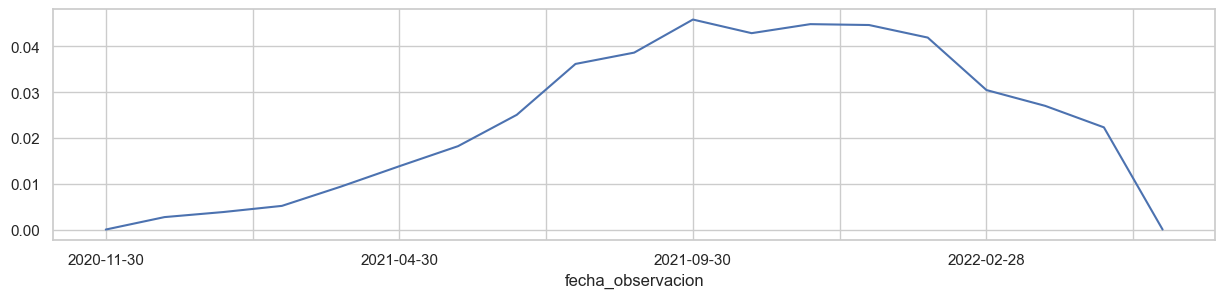

In [59]:
plt.figure(figsize=(15, 3))
df_resumen['bad_rate'].plot()
plt.show()

# Se observa que bad rate fue aumentando con el transcurso de los meses, es decir la distribucion de las variables va cambiando
# probablemente se tenga que testear el modelo mas frecuente 

In [ ]:
# Guardar VD
# para esta poblacion tengo registros duplicados, es decir si un sujeto no paga va aparecer tantas veces hasta que se pague o quede como malo observado
# hay diferentes metodologia de extraer una muestra para que los registros sea linealmente independientes, para este caso voy utilizar la base total


df_vd[["id","fecha_observacion","vd"]].to_parquet(f'{data_dir}complete_data_vd.parquet')

In [61]:
# Poblacion
df_resumen=df_vd[df_vd["fecha_observacion"]<="2021-12-31"].pivot_table(
    columns='vd',
    index='fecha_observacion',
    aggfunc='size',
    fill_value=0
)
df_resumen["bad_rate"]=df_resumen[1]/(df_resumen[0]+df_resumen[1])
df_resumen

vd,0,1,2,4,bad_rate
fecha_observacion,,,,,
2020-11-30,2835,0,0,0,0.0000
2020-12-31,5137,14,0,0,0.0027
2021-01-31,8341,32,0,0,0.0038
2021-02-28,9623,50,0,0,0.0052
2021-03-31,10056,95,0,0,0.0094
2021-04-30,9626,135,0,0,0.0138
2021-05-31,11160,207,0,0,0.0182
2021-06-30,12025,309,0,0,0.0251
2021-07-31,13405,503,1,3,0.0362


### Conclusión Final: Preparación de Datos y Segmentación

1. **Criterio de fechas de corte:**
   - Se estableció el criterio de tomar fechas de corte de manera mensual al final de cada mes. Esto permite analizar retrospectivamente la situación de cada factura en función de su estado al cierre de cada período.

2. **Evolución del `bad rate`:**
   - Se observó un incremento progresivo en el `bad rate` con el paso de los meses, lo que indica que la distribución de las variables puede cambiar con el tiempo.
   - Esto sugiere la necesidad de evaluar el modelo de forma más frecuente para adaptarse a posibles cambios en el comportamiento de los datos.

3. **Selección del conjunto de prueba:**
   - La última fecha de observación considerada fue el 31 de diciembre de 2021, mientras que el período completo de enero de 2022 (hasta el 31 de enero) se reservó para evaluar el modelo con una base de prueba independiente.

4. **Registros duplicados en la población:**
   - En esta población, los registros duplicados representan casos en los que un sujeto aparece repetidamente hasta que realiza el pago o se considera como "malo observado".
   - Existen diversas metodologías para extraer muestras donde los registros sean linealmente independientes. Sin embargo, para este caso, se decidió trabajar con la base total, sin aplicar modificaciones adicionales.

5. **Enfoque del modelo:**
   - Debido a restricciones de tiempo, se avanzó con un modelo general que no incluye segmentación específica.
   - Esto permitirá obtener resultados iniciales rápidamente, aunque en etapas posteriores podría ser valioso explorar modelos segmentados para mejorar el desempeño.
